# Distributed optimization algorithms

___
**Martin Guyard, https://github.com/9OP/CLOUDS**
___

The goal of this notebook is to work on distributed optimization algorithms, which are the foundation for large scale analytics and machine learning. Specifically, we will focus on the details of stochastic gradient descent (SGD). To do so, we will work on a simple regression problem, where we will apply SGD to minimize a loss function, as defined for the problem at hand. The emphasis of this laboratory is **not** on the machine learning part: even if you've never worked on regression problems, this shouldn't prevent you from being successful in developing the Notebook.

Next, an outline of the steps we will follow in this Notebook:

* Brief introduction to linear regression
* Implementation of serial algorithms: from Gradient Descent, to Stochastic Gradient Descent
* Implementation of distributed algorithms with Apache Spark


### Initialization code

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import datetime
from scipy import stats 
from pylab import rcParams

from sklearn.datasets.samples_generator import make_regression
from sklearn import linear_model

## A simple example: linear regression
Let’s see briefly how to use gradient descent in a simple least squares regression setting. Asssume we have an output variable $y$ which we think depends linearly on the input vector $x$. That is, we have:

$$x = \begin{bmatrix}x_1 \\ x_2 \\ \cdots \\ x_m\end{bmatrix}, y = \begin{bmatrix}y_1 \\ y_2 \\ \cdots \\ y_m\end{bmatrix}$$

We approximate $y_i$ by:

$$ f_{\theta}(x_i) = \theta_1 + \theta_2 x_i$$

Define the loss function for the simple linear least squares regression as follows:

$$ J(\theta) = \frac{1}{2} \sum_{i=1}^{m}(f_{\theta}(x_i) - y_i)^2$$

Now, let's use scikit learn to create a regression problem. A few notes are in order:

* The call to ```make_regression``` essentially generates samples for a regression problem
* The call to ```stats.linegress``` calculates a linear least-squares regression for two sets of measurements

This means we have a sort of "basline" to experiment with our SGD implementation.

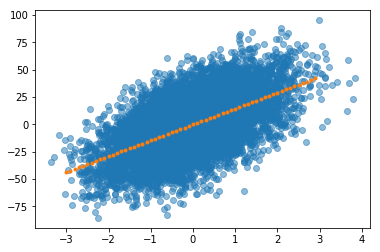

In [2]:
x, y = make_regression(n_samples = 10000, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)
x = x.flatten()
slope, intercept,_,_,_ = stats.linregress(x,y)
best_fit = np.vectorize(lambda x: x * slope + intercept)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')

In [2]:
# Custom functions to avoid redundant code below

def create_data(samples=10000):
    X, y = make_regression(n_samples=samples, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)
    X = X.flatten()
    return X, y

def plot_learning_curve(loss_values, gradient_values):
    rcParams['figure.figsize'] = 16, 8

    # Plot loss over epochs
    plt.subplot(1,2,1)
    plt.plot(loss_values)
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')

    # Plot gradient path
    plt.subplot(1,2,2)
    plt.plot(np.array(gradient_values)[:,0], np.array(gradient_values)[:,1], '->', label='path')
    plt.title('Gradient path')
    plt.xlabel('grad theta_1')
    plt.ylabel('grad theta_2')
    plt.legend(frameon=False)
    plt.show()

    
def plot_regression(X, y, params):
    regression = lambda x: params[0]+x*params[1]
    rcParams['figure.figsize'] = 8,8

    # Plot the regression
    plt.plot([min(X), max(X)], [regression(min(X)), regression(max(X))], 'k--')
    plt.scatter(X, y, s=0.8, alpha=0.6)
    plt.title('Plotted regression')
    plt.ylabel('y - target')
    plt.xlabel('X - feature')
    plt.show()


def plot_gradient_path(gradient_values):
    rcParams['figure.figsize'] = 12, 6

    # Plot gradient path
    plt.subplot(1, 2, 1)
    plt.plot(np.array(gradient_values)[:,0], np.array(gradient_values)[:,1], '->', label='path')
    plt.title('Gradient path')
    plt.xlabel('grad theta_1')
    plt.ylabel('grad theta_2')
    plt.legend(frameon=False)
    
    # Plot gradient convergence
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, len(gradient_values)), np.array(gradient_values)[:,0], label='grad theta1')
    plt.plot(np.arange(0, len(gradient_values)), np.array(gradient_values)[:,1], label='grad theta2')
    plt.title('Gradient convergence')
    plt.xlabel('epochs')
    plt.ylabel('grad value')
    plt.legend(frameon=False)
    plt.show()

    
def plot_3d_model(params_values, X, y):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.gca(projection='3d')

    theta1, theta2 = params_values[:, 0], params_values[:, 1]

    plane_1 = np.arange(int(np.amin(theta1))-10, int(np.amax(theta1))+10, 1)
    plane_2 = np.arange(int(np.amax(theta2))-10, int(np.amax(theta2))+10, 1)

    z = np.ones((len(plane_2), len(plane_1)))
    plane1, plane2 = np.meshgrid(plane_1, plane_2)

    loss_function = lambda  theta1, theta2, X, Y: \
            0.5*sum([(theta1 + x*theta2 - y)**2 for x, y in zip(X, Y)])/len(X)

    for i in range (0, plane1.shape[0]):
        for j in range(0, plane1.shape[1]):
            z[i][j] = loss_function(plane1[i][j], plane2[i][j], X, y)    

    ax.plot_surface(plane1, plane2, z, cmap=cm.coolwarm)
    ax.plot(theta1, theta2, loss_values, color='green')
    ax.set_xlabel("Theta 1")
    ax.set_ylabel("Theta 2")
    ax.set_zlabel("Loss")
    ax.view_init(40, 120)


    fig = plt.figure()
    fig.set_size_inches(10, 8)
    plt.contourf(plane1, plane2, z, cmap=cm.coolwarm)
    plt.plot(theta1, theta2, "->", color='green')
    plt.show()

## Batch gradient descent
Before delving into SGD, let's take a simpler approach. Assume that we have a vector of paramters $\theta$ and a loss function $J(\theta)$, which we want to minimize. The loss function we defined above has the form:

$$ J(\theta) = \sum_{i=1}^{m} J_i(\theta)$$

where $J_i$ is associated with the i-th observation in our data set, such as the one we generated above. The batch gradient descent algorithm, starts with some initial feasible parameter $\theta$ (which we can either fix or assign randomly) and then repeatedly performs the update:

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} J(\theta^{(t)}) = \theta^{(t)} - \eta \sum_{i=1}^{m} \nabla_{\theta} J_i(\theta^{(t)}) $$

where $t$ is an iteration index, and $\eta$ is a constant controlling step-size and is called the learning rate. Note that in order to make a **single update**, we need to calculate the gradient **using the entire dataset**. This can be very inefficient for large datasets, and it is the goal of this Notebook to insist on this aspect.

In code, the main loop for batch gradient descent looks like this:

```python
for i in range(n_epochs):
  params_grad = evaluate_gradient(loss_function, data, params)
  params = params - learning_rate * params_grad
```

For a given number of iterations (also called epochs) $n_{e}$ , we first evaluate the gradient vector of the loss function using **ALL** examples in the data set, and then we update the parameters with a given learning rate. Batch gradient descent is guaranteed to converge to the global minimum for convex loss surfaces and to a local minimum for non-convex surfaces.

<div class="alert alert-warning">
<b>NOTE:</b> Who computes the gradient?
<br>
<br>
Given a loss function $J(\theta)$, the gradient with respect to paramters $\theta$ must be derived manually. In other words, given the expression of $J(\theta)$, pencil and paper are required to derive the analytical form of its gradient. Then this expression can be plugged into our code.

Recently, machine learning libraries have adopted the techniques of **automatic differentiation**, which eliminate this tedious and error prone step. Given a loss function $J(\theta)$, such libraries automatically compute the gradient.
</div>


For the linear regression case, let's derive the update step for gradient descent. Recall that we have defined:

$$ J(\theta) = \frac{1}{2} \sum_{i=1}^{m}(f_{\theta}(x_i) - y_i)^2$$

$$f_\theta(x_i) = \theta_1 + \theta_2 x_i$$

So we have that:

$$ \nabla_\theta J(\theta) = \frac{1}{2} \sum_{i=1}^{m} \nabla_\theta (\theta_1 + \theta_2 x_i - y_i)^2 $$

If we explicit the partial derivatives of the gradient, we have:

$$\frac{\partial J(\theta)}{\partial \theta_1} = \sum_{i=1}^{m} (\theta_1 + \theta_2 x_i - y_i)$$
$$\frac{\partial J(\theta)}{\partial \theta_2} = \sum_{i=1}^{m} (\theta_1 + \theta_2 x_i - y_i) x_i$$

So now we can explicit the update rules for the two model parameters:

$$ \theta_1^{(t+1)} = \theta_1^{(t)} - \eta \sum_{i=1}^{m}  (\theta_1^{(t)} + \theta_2^{(t)} x_i - y_i)$$

$$ \theta_2^{(t+1)} = \theta_2^{(t)} - \eta \sum_{i=1}^{m}  (\theta_1^{(t)} + \theta_2^{(t)} x_i - y_i) x_i$$


### Using matrix notation
Now, before writing some code, let's see how can we simplify the above expressions using matrices. Note that this is not only useful for working on a more compact notation, but it helps reason about efficient computations using libraries such as numpy, which we will use extensively.

We firstly expressed our prediction as: $f_\theta (x_i) = \theta_1 + \theta_2 x_i$. Let's introduce a surrogate dimension for our input set $x$, such that:

$$x = 
\begin{bmatrix} 1& x_{1} \\ 1 & x_{2} \\ \cdots & \cdots \\ 1 & x_{m}\end{bmatrix}
$$

where we define, with a small abuse of notation, $x_i = \begin{bmatrix} 1 & x_{i}\end{bmatrix}$. Also, let's define vector $\theta = \begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix}$. 

Then, we can rewrite $f_\theta(x_i) = x_i \theta = \begin{bmatrix} 1 & x_{i}\end{bmatrix} 
\begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix} = \theta_1 + \theta_2 x_i$.

Let's use this notation to rewrite our gradients in matrix form.


$\nabla_\theta J(\theta) =  \frac{1}{2} \sum_{i=1}^{m} \nabla_\theta (x_i \theta - y_i)^2$


$= \sum_{i=1}^{m} (x_i \theta - y_i) x_i^T =$


$= x^T (x \theta - y) =$


$= \begin{bmatrix} 1 & 1 & \cdots & 1 \\ x_1 & x_2 & \cdots & x_m \end{bmatrix} 
\Bigg( \begin{bmatrix} 1& x_{1} \\ 1 & x_{2} \\ \cdots & \cdots \\ 1 & x_{m}\end{bmatrix} 
\begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix} - 
\begin{bmatrix} y_1 \\ y_2 \\ \cdots \\ y_m\end{bmatrix} \Bigg)$

### Numpy arrays
With the work we did above, we can now cast everything into numpy arrays, which are efficient, and for which an efficient implementation of vector and matrix operations exists. Specifically, above we used the traditional matrix notation, where we manipulate column vectors. Hence, we express matrix operations (namely matrix products) using the traditional "row-by-column" approach.

In numpy, we avoid this formalism by using dot product operations. So, given two column vectors:
$$a= \begin{bmatrix} a_1 \\ a_2 \\ \cdots \\ a_{m}\end{bmatrix} b= \begin{bmatrix} b_1 \\ b_2 \\ \cdots \\ b_{m}\end{bmatrix}$$
we have that $a b^T = a \cdot b = a_1 b_1 + a_2 b_2 + \cdots + a_m b_m$, where $\cdot$ is the symbol we use for dot product.

<div class="alert alert-block alert-info">
<strong>Question 1.</strong> Implement your own version of Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>

The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

**Answer:**
___

In [3]:
def gradient_descent(X, y, params, learning_rate, maxiter=100, eps=1e-6):
    ''' Compute gradient descent for 1D linear regression problem.
    :param X: feature
    :param y: target
    :param params: initial coeff for the linear regression
    :param learning_rate: gradient descent learning rate
    :param maxiter: maximum iteration (stop condition)
    :param eps: epsilon (stop condition)
    '''
    loss_values = []
    gradient_values = []
    params_values = []
    x_ones = np.array([np.ones(X.size), X])
    
    print('Full-batch gradient descent')
    print('\t{:<20}{:<10}'.format('Learning rate:', learning_rate))
    print('\t{:<20}{:<10}'.format('Max iterations:', maxiter))
    print('\t{:<20}{:<10}'.format('Epsilon:', eps))
        
    for i in range(maxiter):
        thetas = x_ones.T.dot(np.array(params))
        loss = 0.5*(thetas-y).dot((thetas-y).T)/X.size
        params_grad = x_ones.dot(thetas-y)/X.size
        
        params = params - learning_rate * params_grad
        
        loss_values.append(loss)
        gradient_values.append(params_grad)
        params_values.append(params)
                
        if i>1 and abs(loss_values[-2]-loss_values[-1])<=eps:
            break
    i += 1        
    print('{:<20}{:<10}'.format('Iterations:', i))
    print('{:<20}{:<10}'.format('Loss rate:', loss_values[-1]))
    print('-'*45+'\n')
            
    return params, np.array(params_values), np.array(gradient_values), np.array(loss_values), i

In [4]:
# My implementation
X, y = create_data()
params, params_values, gradient_values, loss_values, iterations = gradient_descent(X, y, np.array([5, 5]), 0.1)

# Sklearn
gd = linear_model.LinearRegression().fit(X.reshape(-1, 1), y.reshape(-1, 1))

Full-batch gradient descent
	Learning rate:      0.1       
	Max iterations:     100       
	Epsilon:            1e-06     
Iterations:         80        
Loss rate:          201.50907294125764
---------------------------------------------



In [5]:
print('Gradient descent own implementation')
print('Params:', round(params[0],4), round(params[1],4))
print('-'*50)
print('Sklearn gradient descent implementation')
print('Params:',  round(float(gd.intercept_), 4), round(float(gd.coef_), 4))

Gradient descent own implementation
Params: -0.1059 14.5127
--------------------------------------------------
Sklearn gradient descent implementation
Params: -0.1068 14.5152


<div class="alert alert-block alert-sucess">
The params obtained with my own implementation of gradient descent on 1D linear regression give me the same coefs than the Sklean LinearRegression model implementation. <b>However</b>, my implementation is not using batcktracking and with a poorly chosen learning rate, the gradient descent can diverge.

<b>The eps parameters can be changed to have a different stop condition on the step improvement. By default eps is 10E-6</b>
</div>

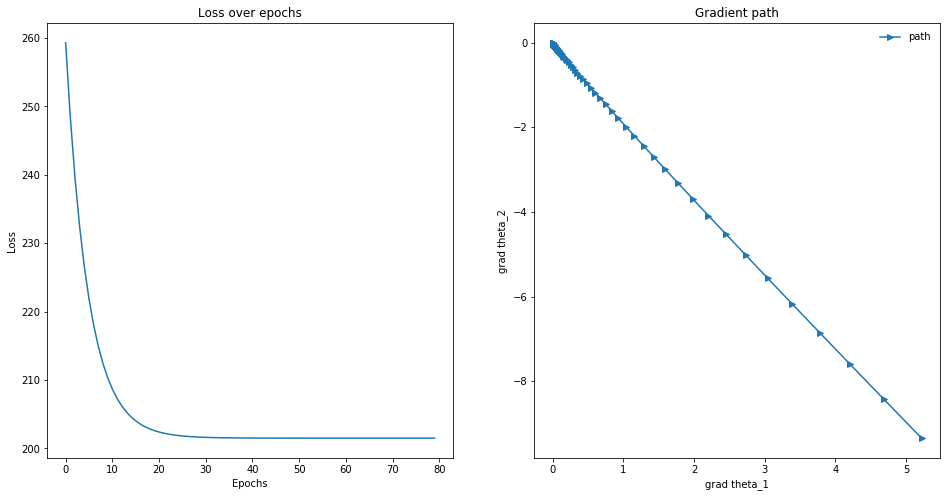

In [6]:
plot_learning_curve(loss_values, gradient_values)

<div class="alert alert-block alert-sucess">
The loss decreased exponentially over the few first epochs and then decrease slowly. The reason might be a fixed learning rate that doesn't not adapt to the gradient evolution. The gradient path converge in the direction of a global minimum, but not exactly at the begining. This is why the path is not linear but curved.
</div>

___

<br>

<div class="alert alert-block alert-info">
<strong>Question 2.</strong> Plot the regression line, along with the training data, given the coefficients $\theta$ that you have obtained with Gradient Descent.
</div>

**Answer:**
____

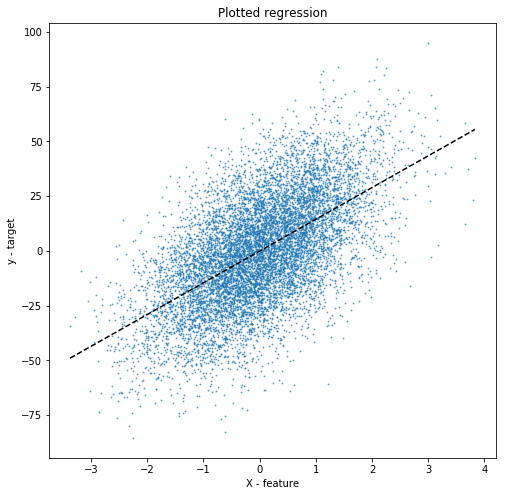

In [7]:
plot_regression(X, y, params)


___

<br>

<div class="alert alert-block alert-info">
<strong>Question 3.</strong> Plot a 3D surface representing: on the x,y axes the parameter values, on the z axis the loss value. Additionally, plot the trajectory of the loss function on the 3D surface, using the history you collected in the gradient_descent function you designed.

Finally, plot a contour projection of the 3D surface, along with the corresponding projection of the trajectory followed by your Gradient Descent algorithm.
</div>

**Answer:**
___

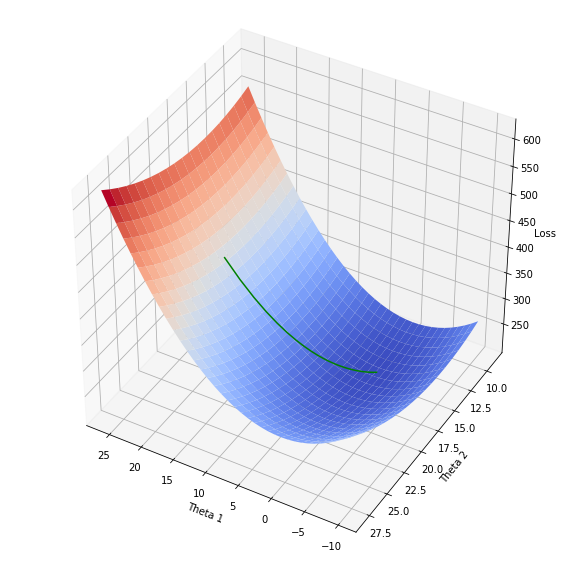

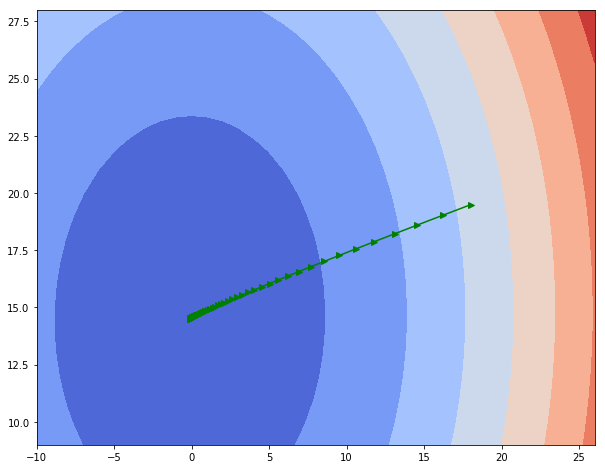

In [25]:
plot_3d_model(params_values, X, y)

<div class="alert alert-block alert-sucess">

</div>

___

<br>

<div class="alert alert-block alert-info">
<strong>Question 4.</strong> Plot the path the gradient takes from its initial to its final position.

This is a two dimensional plot (because our parameter vector has size 2), with a point for each gradient value, and a line connecting the points.
</div>

**Answer:**
___

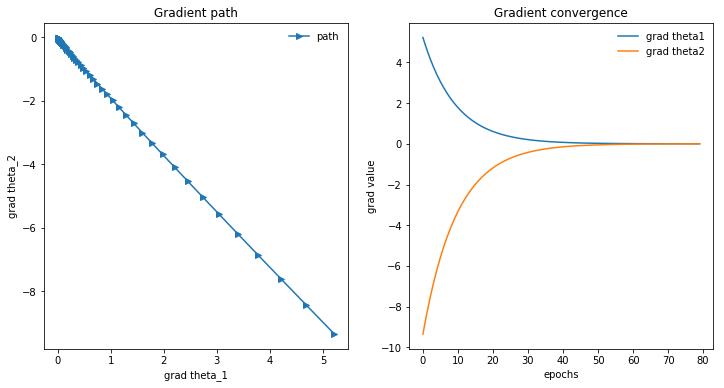

In [37]:
plot_gradient_path(gradient_values)

<div class="alert alert-block alert-sucess">
<b>Note:</b>
This is an expected result since grad (of params) should converge to 0. Here $\nabla{\theta_1}$ and $\nabla{\theta_2}$ converge to $0$
</div>

___

<br>

## Stochastic Gradient Descent

The gradient descent algorithm makes intuitive sense as it always proceeds in the direction of steepest descent (the gradient of $J$) and guarantees that we find a local minimum (global under certain assumptions on $J$). When we have very large data sets, however, computing $\nabla_\theta J(\theta)$ can be computationally challenging: as noted above, we must process every data point before making a single step (hence the name "batch"). 

An alternative approach to alleviate such computational costs is the Stochastic Gradient Descent method: essentially, the idea is to update the parameters $\theta$ sequentially (one data point at the time), with every observation $x_i, y_i$. Following the same notation we used for Gradient Descent, the following expression defines how to update parameters, while processing one data point at the time:

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} J_i(\theta^{(t)}) $$


The stochastic gradient approach allows us to start making progress on the minimization problem one step at the time. It is computationally cheaper, but it results in a larger variance of the loss function in comparison with batch gradient descent.

Generally, the stochastic gradient descent method will get close to the optimal $\theta$ much faster than the batch method, but will never fully converge to the local (or global) minimum. Thus the stochastic gradient descent method is useful when we are satisfied with an **approximation** for the solution to our optimization problem. 

A full recipe for stochastic gradient descent follows:

```python 
for i in range(n_epochs):
  np.random.shuffle(data)
  for example in data:
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
```

The reshuffling of the data is done to avoid a bias in the optimization algorithm by providing the data examples in a particular order.

<div class="alert alert-block alert-info">
<strong>Question 5.</strong> Implement your own version of Stochastic Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>

    
The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

**Answer:**
___

In [8]:
def stochastic_gradient_descent(X, y, params, learning_rate, maxiter=100, eps=1e-6):
    ''' Compute gradient descent for 1D linear regression problem.
    :param X: feature
    :param y: target
    :param params: initial coeff for the linear regression
    :param learning_rate: gradient descent learning rate
    :param maxiter: maximum iteration (stop condition)
    :param eps: epsilon (stop condition)
    '''
    loss_values = []
    gradient_values = []
    params_values = []
    x_ones = np.array([np.ones(X.size), X])
    N = len(X)
    data = np.array(list(zip(X, y)))
    
    print('Stochastic gradient descent')
    print('\t{:<20}{:<10}'.format('Learning rate:', learning_rate))
    print('\t{:<20}{:<10}'.format('Max iterations:', maxiter))
    print('\t{:<20}{:<10}'.format('Epsilon:', eps))
    
    for i in range(maxiter):
        np.random.shuffle(data)
        loss = 0
        gradients = []
        for ex_x, ex_y in data:
            x_ones = np.array([1, ex_x])
            thetas = x_ones.T.dot(np.array(params))
            loss += 0.5*(thetas-ex_y)**2
            params_grad = x_ones.dot(thetas-ex_y)
            
            gradients.append(params_grad)
            
            params = params - learning_rate * params_grad
            
        loss /= N
        loss_values.append(loss)
        gradients = np.array(gradients)
        gradient_values.append([np.mean(gradients[:,0]),np.mean(gradients[:,1])])
        params_values.append(params)
 
        if i>1 and abs(loss_values[-2]-loss_values[-1])<=eps:
            break
    i += 1
    print('{:<20}{:<10}'.format('Iterations:', i))
    print('{:<20}{:<10}'.format('Loss rate:', loss_values[-1]))
    print('-'*45+'\n')
    
    return params, np.array(params_values), np.array(gradient_values), np.array(loss_values), i

In [9]:
X, y = create_data()
params, params_values, gradient_values, loss_values, iterations = stochastic_gradient_descent(X, y, np.array([5, 5]), 0.005)

# Sklearn
sgd = linear_model.SGDRegressor(tol=1e-6, max_iter=100).fit(X.reshape(-1, 1), y)

Stochastic gradient descent
	Learning rate:      0.005     
	Max iterations:     100       
	Epsilon:            1e-06     
Iterations:         100       
Loss rate:          202.46616447332505
---------------------------------------------



In [10]:
print('Stochastic gradient descent own implementation')
print('Params:', round(params[0],4), round(params[1],4))
print('-'*50)
print('Sklearn stochastic gradient descent implementation')
print('Params:',  round(float(sgd.intercept_), 4), round(float(sgd.coef_), 4))

Stochastic gradient descent own implementation
Params: 0.2589 14.8776
--------------------------------------------------
Sklearn stochastic gradient descent implementation
Params: -0.2107 14.4806


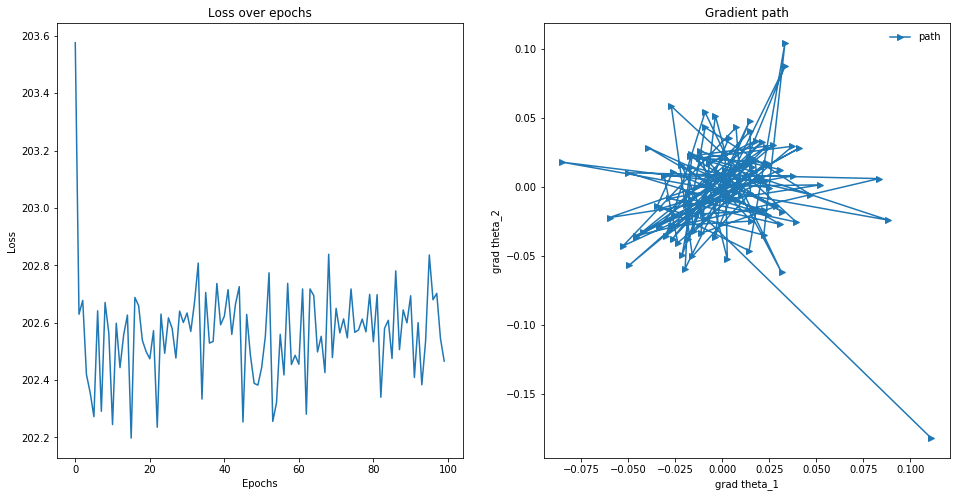

In [11]:
plot_learning_curve(loss_values, gradient_values)

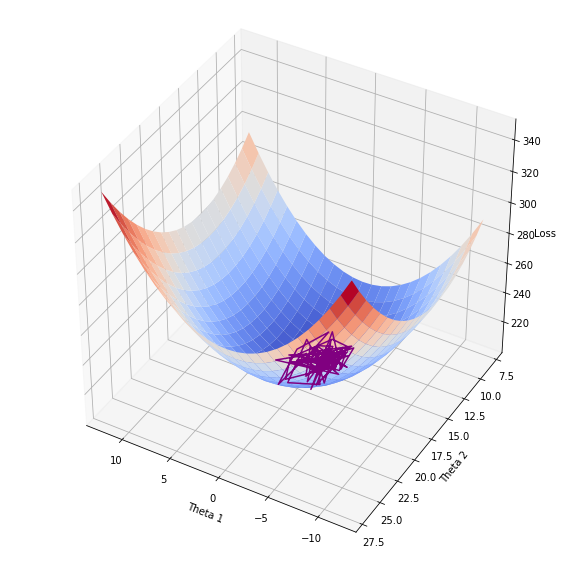

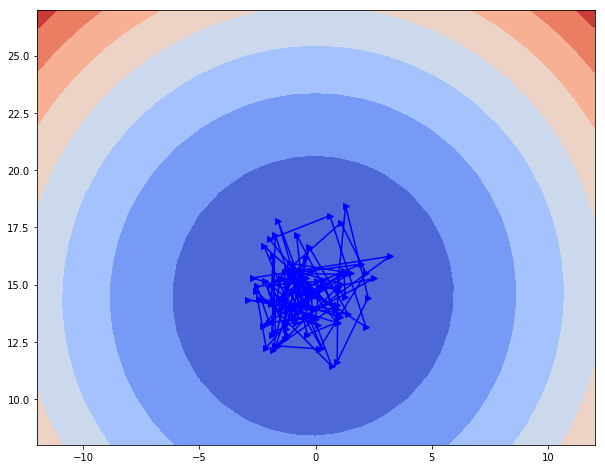

In [59]:
plot_3d_model(params_values, X, y)

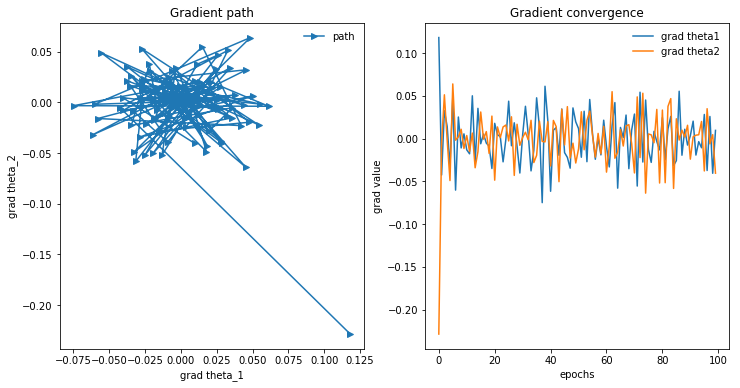

In [47]:
plot_gradient_path(gradient_values)

<div class="alert alert-success">
Stochastic gradient descent performs update for each sample in the dataset. It can reach the optimal an approximate of the optimal value in less epochs than full batch gradient descent. (See how steep is the loss.vs.epoch curve). However it doesn't not converge, as the thetas values keep oscillating around optimal value.

In term of computation time it is faster than full batch to reach an approximate of the optimal. Whereas full batch can require dozens of epochs, stochastic can actually converge in 2-5 epochs in our example above. Then you should be really carefull choosing the maxiter, and eps parameters as they will greatly affect the computation time. Since stochastic interrest is to return an approximate, one should considere loose eps value and small number of iterations.
</div>

___

<br>

## Mini-batch Stochastic Gradient Descent

Mini-batch gradient descent is a trade-off between stochastic gradient descent and batch gradient descent.  In mini-batch gradient descent, the cost function (and therefore gradient) is averaged over a small number of samples, which is what we call the mini-batch, and that we denote by $mb$.  This is opposed to the SGD batch size of 1 sample, and the BGD size of all the training samples. 

Let's use the notation we introduced above to rewrite the gradients in matrix form for the mini-batch variant:

$\nabla_\theta J(\theta) =  \frac{1}{2 mb} \sum_{i=1}^{mb} \nabla_\theta (x_i \theta - y_i)^2$


$= \sum_{i=1}^{mb} (x_i \theta - y_i) x_i^T =$


$= x_{mb}^T (x_{mb} \theta - y_{mb})$


What’s the benefit of doing it this way?  First, it smooths out some of the noise in SGD, but not all of it, thereby still allowing the “kick” out of local minimums of the cost function.  Second, the mini-batch size is still small, thereby keeping the performance benefits of SGD.





<div class="alert alert-block alert-info"> 
<strong>Question 6.</strong> Implement your own version of Mini-batch Stochastic Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to extract mini-batches from the training data.
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>


The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

**Answer:**
___

In [12]:
def next_batch(X, y, b_size):
    for i in np.arange(0, len(X), b_size):
        yield(X[i:i+b_size],y[i:i+b_size])


def mini_batch_gradient_descent(X, y, params, learning_rate, maxiter=100, eps=1e-6, batch=50):
    ''' Compute gradient descent for 1D linear regression problem.
    :param X: feature
    :param y: target
    :param params: initial coeff for the linear regression
    :param learning_rate: gradient descent learning rate
    :param maxiter: maximum iteration (stop condition)
    :param eps: epsilon (stop condition)
    :param batch: number of samples in batch
    '''
    loss_values = []
    gradient_values = []
    params_values = []
    x_ones = np.array([np.ones(X.size), X])
    N = len(X)
    data = np.array(list(zip(X, y)))
    
    print('Mini-batch gradient descent')
    print('\t{:<20}{:<10}'.format('Learning rate:', learning_rate))
    print('\t{:<20}{:<10}'.format('Max iterations:', maxiter))
    print('\t{:<20}{:<10}'.format('Epsilon:', eps))
    print('\t{:<20}{:<10}'.format('Batch:', batch))
    
    for i in range(maxiter):
        np.random.shuffle(data)
        loss = 0
        gradients = []
        for ex_x, ex_y in next_batch(X, y, batch):
            x_ones = np.array([np.ones(len(ex_x)), ex_x])
            thetas = x_ones.T.dot(np.array(params))
            loss += 0.5*(thetas-ex_y).dot((thetas-ex_y).T)/len(ex_x)
            params_grad = x_ones.dot(thetas-ex_y)/len(ex_x)
            
            gradients.append(params_grad)
            
            params = params - learning_rate * params_grad
        
        loss /= (N/batch)
        loss_values.append(loss)
        gradients = np.array(gradients)
        gradient_values.append([np.mean(gradients[:,0]),np.mean(gradients[:,1])])
        params_values.append(params)
 
        if i>1 and abs(loss_values[-2]-loss_values[-1])<=eps:
            break
    i += 1
    print('{:<20}{:<10}'.format('Iterations:', i))
    print('{:<20}{:<10}'.format('Loss rate:', loss_values[-1]))
    print('-'*45+'\n')
    
    return params, np.array(params_values), np.array(gradient_values), np.array(loss_values), i

In [13]:
X, y = create_data()
params, params_values, gradient_values, loss_values, iterations = mini_batch_gradient_descent(X, y, np.array([5, 5]), 0.001)

# Sklearn
mbgd = linear_model.LinearRegression().fit(X.reshape(-1, 1), y.reshape(-1, 1))

Mini-batch gradient descent
	Learning rate:      0.001     
	Max iterations:     100       
	Epsilon:            1e-06     
	Batch:              50        
Iterations:         45        
Loss rate:          201.51744924951808
---------------------------------------------



In [14]:
print('Mini-batch gradient descent own implementation')
print('Params:', round(params[0],4), round(params[1],4))
print('-'*50)
print('Sklearn mini-batch gradient descent implementation')
print('Params:',  round(float(mbgd.intercept_), 4), round(float(mbgd.coef_), 4))

Mini-batch gradient descent own implementation
Params: -0.1116 14.5106
--------------------------------------------------
Sklearn mini-batch gradient descent implementation
Params: -0.1068 14.5152


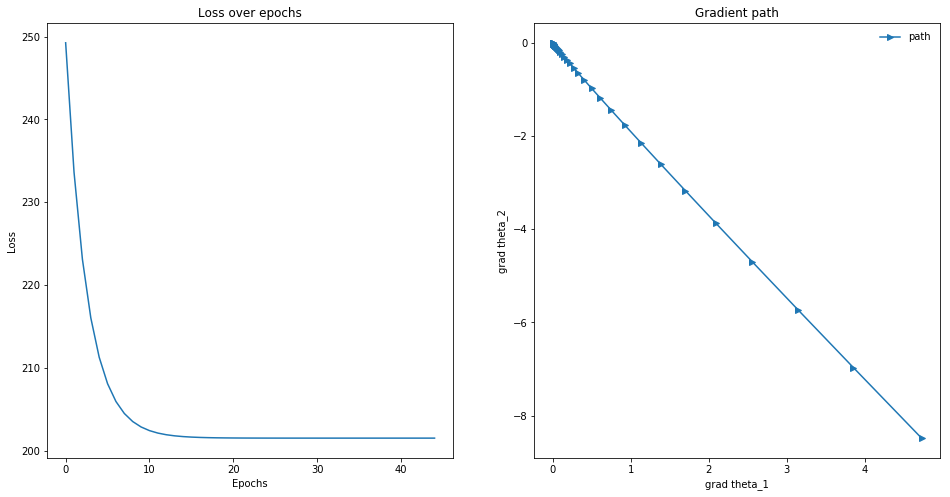

In [15]:
plot_learning_curve(loss_values, gradient_values)

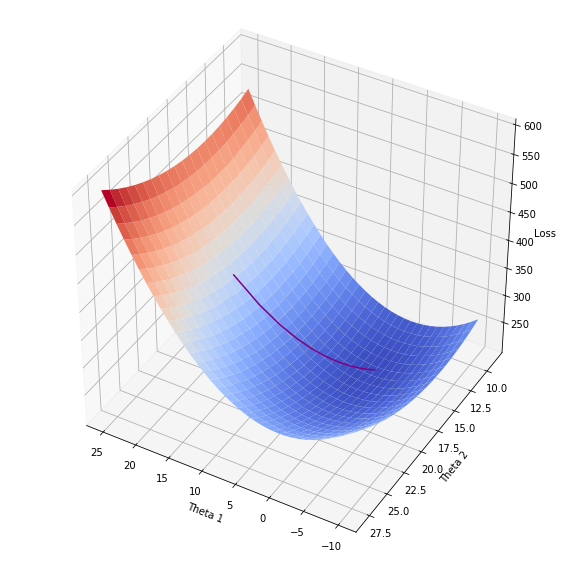

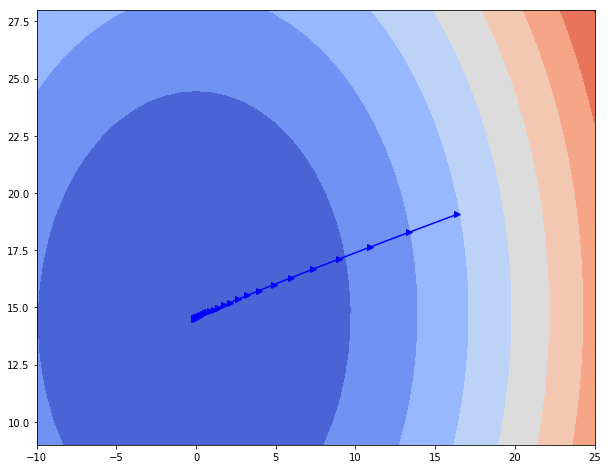

In [72]:
plot_3d_model(params_values, X, y)

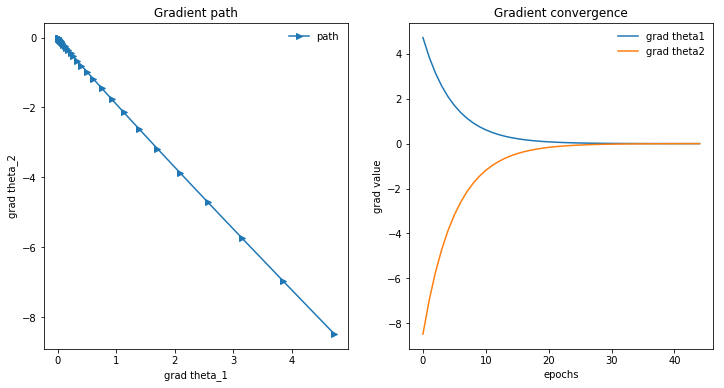

In [51]:
plot_gradient_path(gradient_values)

<div class="alert alert-success">
Mini bacth gradient descent performs gradient update on batch (subset of samples). It is a trade off between fullbatch GD (calulcate gradient on whole dataset) and SGD (calculate gradient on one sample)

The mini batch gradient descent is reaching optimal faster than full batch GD (fewer steps) and do not keep on oscilating like SGD.
</div>

___

<br>

<div class="alert alert-block alert-info">
<strong>Question 7.</strong> Compare the loss rate of the three approachs, Gradient Descent, Stochastic Gradient Descent, Mini-batch Stochastic Gradient Descent, by plotting in the same figure, the loss rate as a function of iterations. 


Comment the behavior of the three algorithms.
</div>

**Answer:**
___


Full-batch gradient descent
	Learning rate:      0.1       
	Max iterations:     100       
	Epsilon:            -0.1      
Iterations:         100       
Loss rate:          201.50906893062884
---------------------------------------------

Stochastic gradient descent
	Learning rate:      0.1       
	Max iterations:     100       
	Epsilon:            -0.1      
Iterations:         100       
Loss rate:          224.04447675043218
---------------------------------------------

Mini-batch gradient descent
	Learning rate:      0.1       
	Max iterations:     100       
	Epsilon:            -0.1      
	Batch:              50        
Iterations:         100       
Loss rate:          201.89524077185303
---------------------------------------------



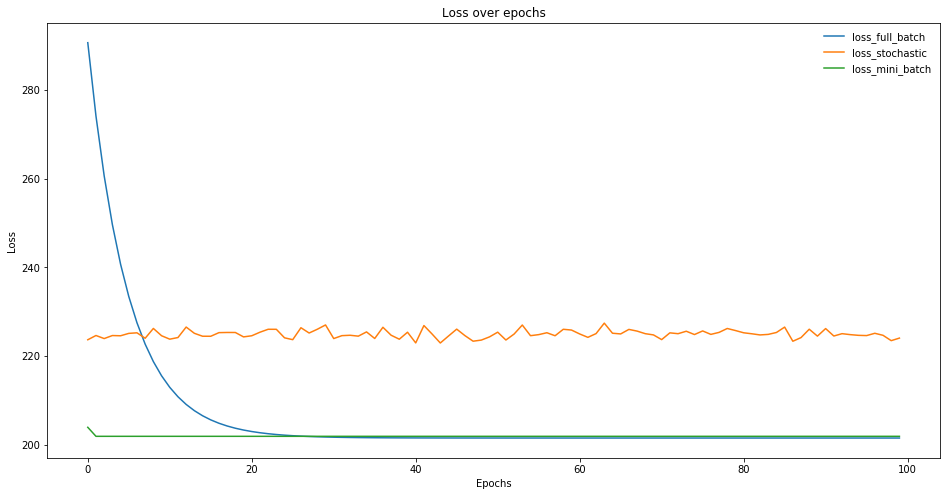

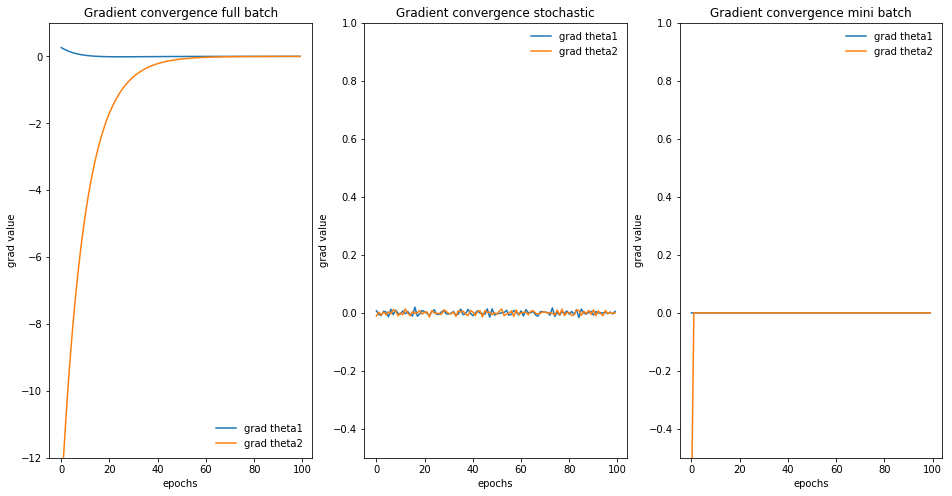

Full-batch gradient descent
	Learning rate:      0.01      
	Max iterations:     100       
	Epsilon:            -0.1      
Iterations:         100       
Loss rate:          214.29331826567076
---------------------------------------------

Stochastic gradient descent
	Learning rate:      0.01      
	Max iterations:     100       
	Epsilon:            -0.1      
Iterations:         100       
Loss rate:          203.3721041624627
---------------------------------------------

Mini-batch gradient descent
	Learning rate:      0.01      
	Max iterations:     100       
	Epsilon:            -0.1      
	Batch:              50        
Iterations:         100       
Loss rate:          201.57165156245108
---------------------------------------------



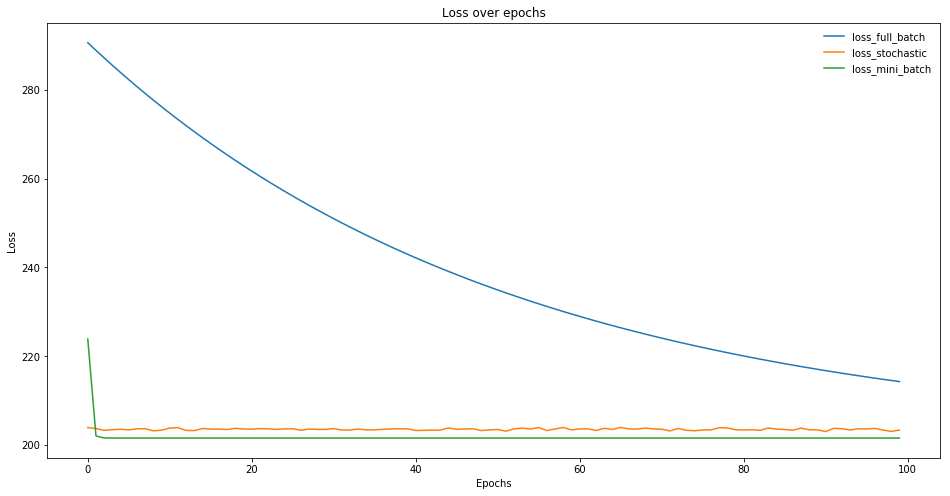

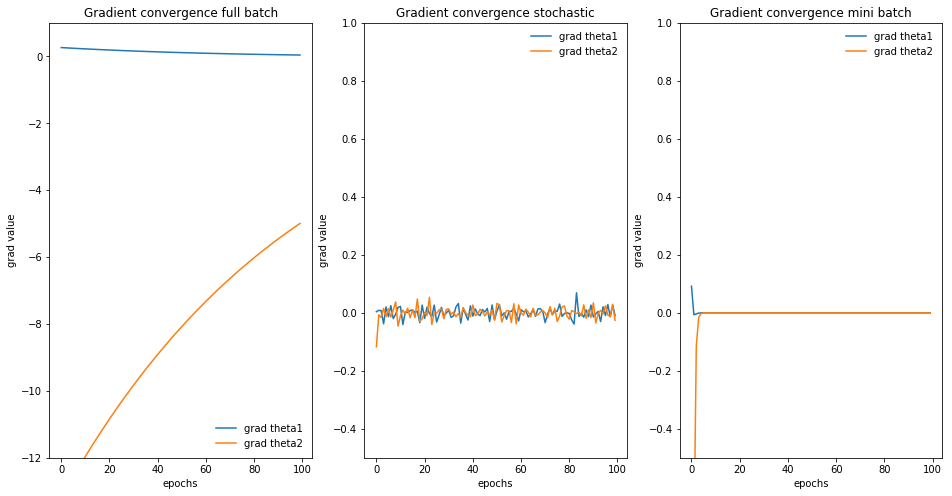

In [54]:
X, y = create_data()

_, _, gradient_full_batch, loss_full_batch, _ = gradient_descent(X, y, np.array([0, 1]), 0.1, eps=-.1)
_, _, gradient_stochastic, loss_stochastic, _ = stochastic_gradient_descent(X, y, np.array([0, 1]), 0.1, eps=-.1)
_, _, gradient_minibatch, loss_mini_batch, _ = mini_batch_gradient_descent(X, y, np.array([0, 1]), 0.1, eps=-.1)


rcParams['figure.figsize'] = 16, 8

# Plot loss over epochs
plt.figure()
plt.plot(loss_full_batch, label='loss_full_batch')
plt.plot(loss_stochastic, label='loss_stochastic')
plt.plot(loss_mini_batch, label='loss_mini_batch')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(frameon=False)
plt.show()

# Plot gradient convergence
plt.subplot(1, 3, 1)
plt.plot(np.arange(0, len(gradient_full_batch)), np.array(gradient_full_batch)[:,0], label='grad theta1')
plt.plot(np.arange(0, len(gradient_full_batch)), np.array(gradient_full_batch)[:,1], label='grad theta2')
plt.title('Gradient convergence full batch')
plt.xlabel('epochs')
plt.ylabel('grad value')
plt.ylim(-12, 1)
plt.legend(frameon=False)

plt.subplot(1, 3, 2)
plt.plot(np.arange(0, len(gradient_stochastic)), np.array(gradient_stochastic)[:,0], label='grad theta1')
plt.plot(np.arange(0, len(gradient_stochastic)), np.array(gradient_stochastic)[:,1], label='grad theta2')
plt.title('Gradient convergence stochastic')
plt.xlabel('epochs')
plt.ylabel('grad value')
plt.ylim(-.5, 1)
plt.legend(frameon=False)

plt.subplot(1, 3, 3)
plt.plot(np.arange(0, len(gradient_minibatch)), np.array(gradient_minibatch)[:,0], label='grad theta1')
plt.plot(np.arange(0, len(gradient_minibatch)), np.array(gradient_minibatch)[:,1], label='grad theta2')
plt.title('Gradient convergence mini batch')
plt.xlabel('epochs')
plt.ylabel('grad value')
plt.legend(frameon=False)
plt.ylim(-.5, 1)
plt.show()



_, _, gradient_full_batch, loss_full_batch, _ = gradient_descent(X, y, np.array([0, 1]), 0.01, eps=-.1)
_, _, gradient_stochastic, loss_stochastic, _  = stochastic_gradient_descent(X, y, np.array([0, 1]), 0.01, eps=-.1)
_, _, gradient_minibatch, loss_mini_batch, _  = mini_batch_gradient_descent(X, y, np.array([0, 1]), 0.01, eps=-.1)

# Plot loss over epochs
plt.figure()
plt.plot(loss_full_batch, label='loss_full_batch')
plt.plot(loss_stochastic, label='loss_stochastic')
plt.plot(loss_mini_batch, label='loss_mini_batch')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(frameon=False)
plt.show()

# Plot gradient convergence
plt.subplot(1, 3, 1)
plt.plot(np.arange(0, len(gradient_full_batch)), np.array(gradient_full_batch)[:,0], label='grad theta1')
plt.plot(np.arange(0, len(gradient_full_batch)), np.array(gradient_full_batch)[:,1], label='grad theta2')
plt.title('Gradient convergence full batch')
plt.xlabel('epochs')
plt.ylabel('grad value')
plt.ylim(-12, 1)
plt.legend(frameon=False)

plt.subplot(1, 3, 2)
plt.plot(np.arange(0, len(gradient_stochastic)), np.array(gradient_stochastic)[:,0], label='grad theta1')
plt.plot(np.arange(0, len(gradient_stochastic)), np.array(gradient_stochastic)[:,1], label='grad theta2')
plt.title('Gradient convergence stochastic')
plt.xlabel('epochs')
plt.ylabel('grad value')
plt.ylim(-.5, 1)
plt.legend(frameon=False)

plt.subplot(1, 3, 3)
plt.plot(np.arange(0, len(gradient_minibatch)), np.array(gradient_minibatch)[:,0], label='grad theta1')
plt.plot(np.arange(0, len(gradient_minibatch)), np.array(gradient_minibatch)[:,1], label='grad theta2')
plt.title('Gradient convergence mini batch')
plt.xlabel('epochs')
plt.ylabel('grad value')
plt.legend(frameon=False)
plt.ylim(-.5, 1)
plt.show()

<div class="alert alert-success">
For the same parameters (inital thetas, learning step, number of iterations) the behavior of the 3 alrogithms is different. SGD seems to converge faster to an optimal approximate, then mini batch converge to optimal faster than full batch.
<br>
I would always prefer mini batch over SGD and full-batch, for the simple reason that SGD and full batch behaviors can be reproduced by mini batch if given the appropriate batch size (1 for SGD, len(dataset) for full batch). 
<br>
<br>
For a learning step = 0.1 (figure top), the full batch GD started from high loss values before reaching optimum after 30 epochs. SGD never reached optimum but rather an approximate really quickly (after 1 epoch) and kept oscillating around it. (no doubt that with a smaller learning step, the approximation and oscillation of SGD would be smaller). Then mini batch GD reached the global optimum in very few epochs (3 or 4).    
<br>
<br>
For a learning step = 0.001 (figure bottom), the behaviour is different. The full batch is converging very slowly (after 100 epochs it has not reached optimal), SGD converge very fast (faster than mini batch) to a closer approximate of optimal and with less oscillation than with the the learning step = 0.1
Mini batch still converge fast enough to the optimal.
</div>

___

<br>
<br>

## Distributed Mini-Batch Stochastic Gradient Descent
We're now ready to study the problem of distributed, mini-batch stochastic gradient descent. Clearly, so far we've worked with very small datasets: as a consequence it is hard to appreciate the computational bottleneck of serial implementations. But before we delve into an experimental setting, and try to spice things up with larger datasets, let's focus on the problem per se.

The problem statement is as follows: we need to design a distributed version of the algorithm we examined above, that is the Mini-Batch Stochastic Gradient Descent. In the interest of time, and also because in this laboratory we want to work with Apache Spark, we will look at **synchronous** distributed algorithms. Don'y worry, things will be much more clear in the next section!

As a complement to this introduction, here's a list of references that are useful for this Notebook, and more generally that constitute the base for those of you interested in distributed optimization algorithms, an important element of large-scale machine learning.

The first reference is a research paper that was published in 2010, in a very important conference called NIPS. I suggest to have a look at section 1 only, unless you want to pursue a PhD, in which case I strongly suggest to contact me, I'm always looking for bright students to work with!

The following references are a collection of pointers to real code, which essentially implement the ideas presented in the research paper we mentioned. Beware, this is Scala code, whereas we use Python. Nevertheless, you'll find a lot of inspiring hints for your own code. Again, I suggest to start simple, and avoid the regularization part. On another note, it is interesting to look at code that is meant to be integrated as a contribution to a popular open source software, such as Apache Spark, and in particular MLLib. This is in stark contrast to the "coding style" we adopt in this Notebook, which is to be considered experimental, and far from being compliant with any principled approach to software engineering.


#### References
* Parallelized Stochastic Gradient Descent: http://martin.zinkevich.org/publications/nips2010.pdf
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/main/scala/org/apache/spark/mllib/optimization/ParallelizedSGD.scala
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/main/scala/org/apache/spark/mllib/optimization/SGDUpdater.scala
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/test/scala/org/apache/spark/mllib/optimization/ParallelizedSGDSuite.scala

### Some useful hints to design your distibuted algorithm

In this Notebook we will use Apache Spark, which is simply a fantastic tool! As we've learned in class (and this is actually true for Hadoop MapReduce as well as for any other distributed computing framework embracing the Bulk Synchrnous Parallel (BSP) programming model), Apache Spark features a synchronization barrier that really helps in dealing with distributed computations. To simplify the discussion (a much more profound treatment of the subject can be found in this nice book http://www.parallel-algorithms-book.com/), in Apache Spark workers operate synchronously, in that the result of their computation, when aggregated or distributed, is processed only when **all** workers are done. So on the one hand, this simplifies the programming model, while on the other hand, this might introduce "stragglers", that is slow workers that penalize the performance of your distributed algorithm.

So what are the basic steps you should follow to design and implement your distributed algorithm?

#### Algorithm pseudo-code
In what follows, we outline the algorithm pseudo-code, to help you think about your algorithm implementation.

```python
for i in range(iterations)
  
  # Randomly partition the input, giving T examples to each machine.
  mini_batches = sample(input_data)

  # Initialize random paramters
  params = initialize
  
  # This part executes in parallel, on each of the k worker machines
  # This is essentially the same code as for the serial implementation
  # Indeed, we're working on an embarassingly parallel formulation
  for data in mini_batch: 
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
    
  # Here we aggregate from all machines, and compute the update for iteration i
  # The update is simply the average of all updates coming from each of the k worker machines
  Aggregate from all computers params = average(params_k)
```

#### Input data and parameters
As for the input data, we want to use the same procedure we used from the beginning of the Notebook: we use scikit learn to generate our $x$ and $y$.
Then, you have to find ways to **partition** this data across the machines you have in your cluster. The method ```sc.parallelize``` comes handy here.

Once you have a parallel collection, that takes the form of an ```RDD```, you'll have to ```sample``` from it, to create random mini batches, each of which will be used **independently** by each worker machine to process its own data. Be careful that here we want to **keep the data partitioning** of our original data. You should be wise enough to lookup for the PySpark API to get the details of the methods we suggested here: ```sample``` and ```mapPartitions```.

Last but not least, we have to take care about the parameters! The initial parameter values, as well as any updates to them, must be shipped to all worker machines. There are various ways to do this, exploiting the great flexibility of Apache Spark. This data could be serialized and shipped along with the code each task should execute. However, a much more efficient method to do this is to exploit what we have learned in class, namely ```broadcast variables```. You might argue that for our simple Notebook, since the parameter vector is of size 2, this is not a big deal. However, for different scenarios, like big models, having an efficient primitive to ship a lot of data to workers is a big plus: remember that broadcast variables are sent to workers using a protocol very similar to BitTorrent, a famous peer-to-peer content distribution system.

#### Driver vs. workers

Now, to clarify even further what we expect from our Apache Spark program, here's some additional information about the roles of each component invovled in the execution of the pseudo-code outlined above.


Essentially, the ```driver``` machine (the one where the ```SparkContext``` is created), is the one responsible for executing the "serial" part of the algorithm: prepare and dispatch data, and wait for the contributions coming from all machines.


Instead, the ```worker``` machines receive their task to execute, proceed independently (some faster than others), and send their updates to the driver. The driver will **wait for all updates from workers** before proceeding with the final aggregation.

#### Additional hints

As you might have heard in class, Apache Spark has a lot of surprises. On of such cool methods allow you to define the way data is aggregated. Indeed, you surely realized that (in the old Hadoop MapReduce jargon) we're talking about a "map only job": workers "map" on their minibatch, computing partial gradient updates, then send everything (more or less at the same time) to the driver machine. At the scale of this Notebook, this is rather harmless. Instead, at larger scale, this could create "congestion" in the driver: a nice solution to this would be to have the possibility to aggregate data along a tree-structure, which would involve worker machines as well as the driver.


One final note. In case you wonder how to produce an ```iterable``` in python with a singleton in it, just ```return (variable, )```.

<div class="alert alert-block alert-info">
<strong>Question 8.</strong> Implement your own version of Mini-Batch, Stochastic Gradient Descent, as a **distributed** algorithm.

    
The output of your cell should contain the following information:
<ul>
<li> The values of the paramters obtained through Gradient Descent optimization </li>
<li> The values of the paramters obtained with the above cell, using scikitlearn </li>
<li> A plot of the loss versus iterations </li>
<li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

**Anwer:**
___

In [28]:
# Spark context
sc

<SparkContext master=spark://spark-master0-104803-prod:7077 appName=pyspark-shell>

In [26]:
def distributed_mini_batch_gradient_descent(X, y, params, learning_rate, maxiter=100, eps=1e-6, partitions=8):
    ''' DISTRIBUTED (SPARK) gradient descent for 1D linear regression problem.
    :param X: feature
    :param y: target
    :param params: initial coeff for the linear regression
    :param learning_rate: gradient descent learning rate
    :param maxiter: maximum iteration (stop condition)
    :param eps: epsilon (stop condition)
    :param partitions: number of worker to use
    '''
    loss_values = []
    gradient_values = []
    params_values = []
    
    def compute_batch_gradient(data):
        # data is an iterable zip(x, y)
        ex_x, ex_y = zip(*data) # unzip
        samples = len(ex_x)
        
        x_ones = np.array([np.ones(samples), ex_x])
        thetas = x_ones.T.dot(np.array([theta1.value, theta2.value]))
        loss = 0.5*(thetas-ex_y).dot((thetas-ex_y).T)
        gradient = x_ones.dot(thetas-ex_y)
       
        yield gradient/samples, loss/samples
  
    sample_split = 1/partitions
    theta1 = sc.broadcast(params[0])
    theta2 = sc.broadcast(params[1])
    theta_array = np.array(params)
    rate = sc.broadcast(learning_rate)
    
    data = np.array(list(zip(X, y)))
    rdd_data = sc.parallelize(data, partitions)
    
    print('Distributed mini-batch gradient descent')
    print('\t{:<20}{:<10}'.format('Learning rate:', learning_rate))
    print('\t{:<20}{:<10}'.format('Max iterations:', maxiter))
    print('\t{:<20}{:<10}'.format('Epsilon:', eps))
    print('\t{:<20}{:<10}'.format('Partitions:', partitions))
    
    for i in range(maxiter):
        mini_batch = rdd_data.sample(False, 0.6)

        resultmap = mini_batch.mapPartitions(compute_batch_gradient)
        result = resultmap.reduce(lambda ex, ey : [ex[0]+ey[0], ex[1]+ey[1]])

        gradient = result[0]/partitions
        loss = result[1]/partitions
        theta_array = theta_array - learning_rate * gradient
        
        gradient_values.append(gradient)
        params_values.append(theta_array)                         
        loss_values.append(loss)
        
        theta1 = sc.broadcast(theta_array[0])
        theta2 = sc.broadcast(theta_array[1])
        
        if i>1 and abs(loss_values[-2]-loss_values[-1])<=eps:
            break
            
    i += 1
    print('{:<20}{:<10}'.format('Iterations:', i))
    print('{:<20}{:<10}'.format('Loss rate:', loss_values[-1]))
    print('-'*45+'\n') 
    
    return theta_array, np.array(params_values), np.array(gradient_values), np.array(loss_values), i

In [27]:
X, y = create_data()
params, params_values, gradient_values, loss_values, iterations = \
    distributed_mini_batch_gradient_descent(X, y, np.array([10, 10]), 0.01, maxiter=400)

Distributed mini-batch gradient descent
	Learning rate:      0.01      
	Max iterations:     400       
	Epsilon:            1e-06     
	Partitions:         8         
Iterations:         400       
Loss rate:          199.4040008826437
---------------------------------------------



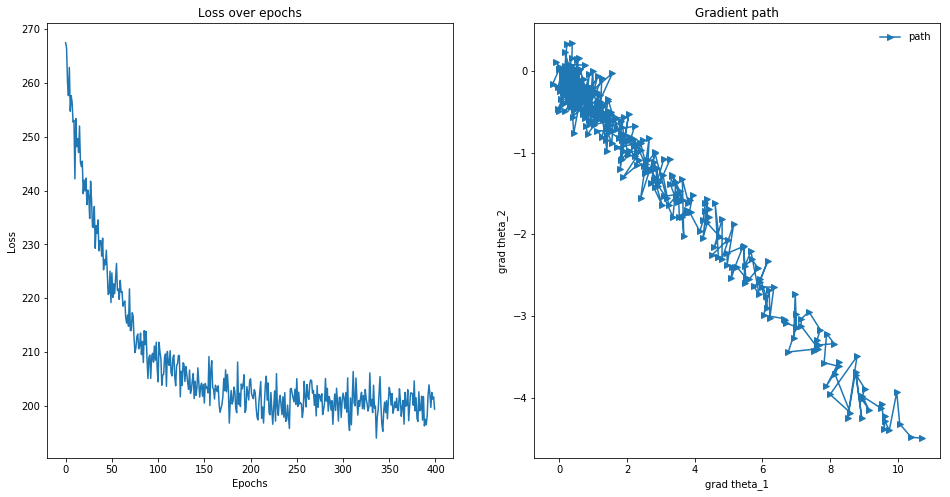

In [28]:
plot_learning_curve(loss_values, gradient_values)

<div class="alert alert-success">
The result is relevant with previous implementation, loss converge to optimal (arround 200), gradient of theta1/theta2 converge to 0, this is the expected behaviour.
<br>    
The workers are iterating on a batch of data computing gradient and loss for the batch. Then the driver reduce the mapPartitions by key, compute the average of gradient and loss of the workers, as well as computing the descent (update of theta_array). 
    
The distributed part happens when each worker can compute gradient and loss on the received batch. Then the driver waits for every worker to finish the computation and compute mean of loss and gradients.
</div>

___


<br>

<div class="alert alert-block alert-info">
<strong>Question 9.</strong> Inspecting your input data, and its partitioning.
<br>

Answer the following questions:
<ul>
    <li>What is the best way to partition your data, given your cluster configuration? How many partitions did you chose</li>
    <li>Given the number of partitions from the first point, how many RDD blocks is your data broken into?</li>
    <li>What would be different if you were to concieve the same algorithm digesting input data stored as a CSV file on HDFS? Argue about how to "ship" data to worker machines, partitions, blocks, etc...</li>
</ul>
</div>


**```[HINT]```** The questions above are best answered by looking at the Spark Master Web UI.

**Answer:**
___

<div class="alert alert-success">
  <ul>
  <li>
Idealy you would like to use all the available workers equally to ensure that the algorithm bacthes gradient computation are indeed run concurently on different nodes. Given this cluster configuration (2 workers * 2 cores = 4 partitions or 8 or 12 ...) would enable the data to be equaly balanced accross the nodes. I set the number of partitions to 8 as default. In practice you would indeed prefer to have 2 or 3 times number of cores, partitions, to make sure the data is well balanced accross the nodes.
      
Having too few partitions will cause bottleneck and prevent the algorithm to run concurently (1 partitions = serial algorithm). Having too many partitions will cause complexe scheduling and overhead management which eventually impact the performance as well. 
  </li>
  <li>
Observing Spark Master Web UI, there are 7 RDD blocks for the workers, same does the driver.
  </li>
  
  <li>
In this current case, data is generated on the driver node and then partitionned over the worker nodes. A different case is to consider the data already splitted on the different nodes (example: a CSV file on HDFS). textFile() should be used to load a csv file from the HDFS. Since the file is on the HDFS spark should preserve locality of data on nodes.
  </li>
</ul>
</div>


<br>


___

<br>

<div class="alert alert-block alert-info">
<strong>Question 10.</strong> Finding bottlenecks.

<ul>
    <li>What is the bottleneck in the current implementation of your algorithm?</li>
    <li>Can you nail down exactly which method is causing this bottleneck?</li>
    <li>Can you suggest ways to mitigate or eliminate the bottleneck?</li>
</ul>
</div>

**Answer:**
___

<div class="alert alert-success">
  <ul><li>The main bottelneck is caused by the synchronous aspect of the algorithm. All partitions have to send their reduced value to the driver node. The driver spends linear time on the number of partitions. This becomes a bottleneck when their are too many partitions.</li>
  <li>Reduce method is causing the bottleneck.</li>
  <li>One way to reduce the bottleneck is to begin aggregation at the worker level not the driver level. This means partially combining results of worker groups with aggregation trees for instance, before data are sent back to the driver. The functions to use are treeAggregate() and treeReduce().</li></ul></div>

___

<br>

<div class="alert alert-block alert-info">
<strong>Question 11.</strong> Comparison of serial vs. distributed algorithms.
</div>

Given all the implementation effort you did so far, this question is about an experimental study on scalability. Given input data sizes in the range $[10^2, 10^3, 10^4, 10^5]$, collect the run-time and the loss rate at convergence for all variants of the serial algorithms and for the distributed one. Produce a plot with 2 y-axis, one for the run-time, one for the loss rate, and one x-axis with the input data size.

Discuss your results.


In [13]:
import time

data_sizes = [1e2, 1e3, 1e4, 1e5]
algorithms = [gradient_descent, 
              stochastic_gradient_descent, 
              mini_batch_gradient_descent, 
              distributed_mini_batch_gradient_descent]

learning_rates = [0.1, 0.001, 0.001, 0.001]
losses = []
runtimes = []

for size in data_sizes:
    X, y = create_data(samples=int(size))
    
    l, t = [], []
    for descent, rate in zip(algorithms, learning_rates):
        start = time.time()
        _, _, _, loss, _, = descent(X, y, np.array([10, 10]), rate, maxiter=200, eps=1e-4)
        end = time.time()
        runtime = end - start
        l.append(loss[-1])
        t.append(runtime)
        
    losses.append(l)
    runtimes.append(t)

Full-batch gradient descent
	Learning rate:      0.1       
	Max iterations:     200       
	Epsilon:            0.0001    
Iterations:         92        
Loss rate:          193.50487334511797
---------------------------------------------

Stochastic gradient descent
	Learning rate:      0.001     
	Max iterations:     200       
	Epsilon:            0.0001    
Iterations:         85        
Loss rate:          193.8534657705396
---------------------------------------------

Mini-batch gradient descent
	Learning rate:      0.001     
	Max iterations:     200       
	Epsilon:            0.0001    
	Batch:              50        
Iterations:         200       
Loss rate:          1362.63838328729
---------------------------------------------

Distributed mini-batch gradient descent
	Learning rate:      0.001     
	Max iterations:     200       
	Epsilon:            0.0001    
	Partitions:         8         
Iterations:         200       
Loss rate:          1771.6281717405918
----------

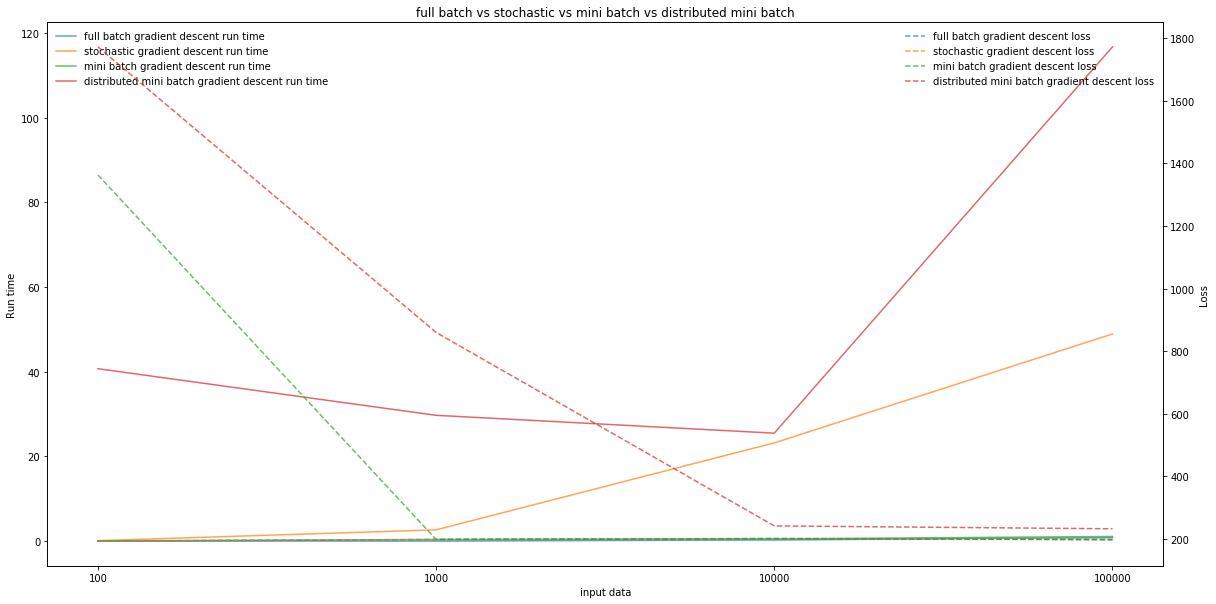

In [19]:
runtimes = np.array(runtimes)  
losses =np.array(losses)


fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()
ticks =  ['100','1000','10000','100000']
N = len(ticks)
plt.xticks(np.arange(0,4), ticks)
ax1.set_xlabel('input data')

ax1.set_ylabel('Run time')
ax2.set_ylabel('Loss')

# full batch gradient descent
ax1.plot(ticks, runtimes[:, 0][:N], '-', label='full batch gradient descent run time', alpha=0.7)
ax2.plot(ticks, losses[:, 0][:N], '--', label='full batch gradient descent loss', alpha=0.7)

# stochastic gradient descent
ax1.plot(ticks, runtimes[:, 1][:N], '-', label='stochastic gradient descent run time', alpha=0.7)
ax2.plot(ticks, losses[:, 1][:N], '--', label='stochastic gradient descent loss', alpha=0.7)

# mini batch gradient descent
ax1.plot(ticks, runtimes[:, 2][:N], '-', label='mini batch gradient descent run time', alpha=0.7)
ax2.plot(ticks, losses[:, 2][:N], '--', label='mini batch gradient descent loss', alpha=0.7)

# distributed mini batch gradient descent
ax1.plot(ticks, runtimes[:, 3][:N], '-', label='distributed mini batch gradient descent run time', alpha=0.7)
ax2.plot(ticks, losses[:, 3][:N], '--', label='distributed mini batch gradient descent loss', alpha=0.7)

plt.title("full batch vs stochastic vs mini batch vs distributed mini batch")
ax1.legend(frameon=False, loc='upper left')
ax2.legend(frameon=False, loc='upper right')

plt.show()

fig.savefig('scale_comparaison.png')


<div class="alert alert-success">
  <strong>Comments</strong>
  <br>
Distributed and mini batch loss decreased with the number of samples. Batch and mini batch scales linearly with the dataset size. The runtimes of full batch and mini batch stay very low (under 2s). This might be due to the performance of numpy and the fact that the entire dataset fits into memory. Distributed mini batch does not seem to be any better than serial gradient descent. The reason is surely that the configuration (2 worker * 2cpu = 4 cores) is very similar to the driver node.
    
For a dataset of size 1E+5, serial full batch and and mini batch are still better than distributed.
    
The main problem to assess scalability here is the environnment.
    
The cloud configuration is very close to a single machine (4cores). The entire dataset can fit into memory. The plotted chart above show that for small dataset (less than 1 million) distributed gradient descent is worse in term of runtime and loss rate.
  <br>
  <br>
The distributed version loss is decreasing with the number size of the dataset. The runtime of the stochastic gradient descent is actually increasing with the data set size this is due to the fact that numpy module is not used in the SGD.

  <br>
  <br>
The main difference between these algorithms is that the distributed gradient descent is easy to scale. You only have to add more workers to the clusters and that's all. More, the data set is not required to fit on the memory of a single worker. Where for serial version, scalability is not easy and the dataset has to fit on the entire memory of the machine.
    
With the present configuration (2workers*2cpus) it is difficult to show that the distributed version would actually scale better. 
    
I would say that for this specific use case (small data size) sticking with full batch and serial mini batch will gave better performance.
  <br>
  <br>
Commenting on the loss values does not really make sense since it depends a lot on the number of iterations and learning rate, and epsilon condition.
  </div>